# 결정 트리 (Decision Tree) - 분류

- 스무고개처럼 질문/결정을 통해 데이터를 분류하는 모델
    - 데이터 스케일링 영향이 적음
    - 선형 구조가 아닌 족잡한 구조의 데이터에 적합
    - 과대적합 되기 쉬움 -> 가지치기 등을 통해 과대적합 방지

**하이퍼 파라미터**

<table>
  <thead>
    <tr>
      <th>파라미터 명</th>
      <th>설명</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>max_depth</code></td>
      <td>
        트리의 최대 깊이를 규정 (디폴트: None) <br>
        None으로 설정하면 완벽하게 클래스 결정 값이 될 때까지 깊이를 계속 키우며 분할하거나 노드가 가지는 데이터 개수가 <code>min_samples_split</code>보다 작아질 때까지 계속 깊이를 증가시킴 <br>
        깊이가 길어지면 <code>min_samples_split</code> 설정대로 최대 분할하여 과적합할 수 있으므로 적절한 값으로 제어 필요
      </td>
    </tr>
    <tr>
      <td><code>max_features</code></td>
      <td>
        최적의 분할을 위해 고려할 최대의 피처 개수 (디폴트: None / 데이터셋의 모든 피처를 사용해 분할 수행)
        <ul>
          <li><code>int</code> 형으로 지정하면 대상 피처의 개수, <code>float</code> 형으로 지정하면 전체 피처 중 대상 피처의 퍼센트</li>
          <li><code>'sqrt'</code>는 전체 피처 중 sqrt(전체 피처 개수) 즉, 전체 피처 개수의 제곱근만큼 선택</li>
          <li><code>'auto'</code>로 지정하면 sqrt와 동일</li>
          <li><code>'log'</code>는 전체 피처 중 log2(전체 피처 개수) 선택</li>
          <li><code>'None'</code>은 전체 피처 선택</li>
        </ul>
      </td>
    </tr>
    <tr>
      <td><code>min_samples_split</code></td>
      <td>
        노드 분할을 위한 최소 samples (디폴트 : <code>min_samples_split=2</code> == 부모노드의 sample수가 2 이상인 경우 분할, 자식노드의 sample수가 2이하일 수 있음) <br>
        작게 설정할 수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>min_samples_leaf</code></td>
      <td>
        분할 이후 만족시켜야 할 sample 최소 개수 (<code>min_samples_leaf=2</code>일 때, 분할 이후 자식노드의 sample수가 2개 이상이 된다면 부모노드를 분할) <br>
        작게 설정할수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>max_leaf_nodes</code></td>
      <td>분할 이후 leaf_node 최대개수</td>
    </tr>
    <tr>
      <td><code>criterion</code></td>
      <td>
        분할을 위해 사용할 성능 평가 지표 설정 <br>
        <code>gini</code> 또는 <code>entropy</code> 값을 사용할 수 있으며, <code>gini</code>는 지니 계수를, <code>entropy</code>는 정보 이득을 기반으로 분할 기준을 결정
      </td>
    </tr>
    <tr>
      <td><code>min_weight_fraction_leaf</code></td>
      <td>
        리프 노드가 전체 가중치에서 차지해야 하는 최소 비율 (디폴트: 0) <br>
        특정 클래스의 데이터가 지나치게 적은 경우 과적합을 방지하기 위해 사용
      </td>
    </tr>
  </tbody>
</table>

##### graphviz 설치
- 그래프 시각화를 위한 오픈소스 소프트웨어 도구
1. os에 설치
2. python wrapper package 설치
3. plot_tree 사용

In [106]:
# !pip install graphviz

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### wine 이진 분류
- 와인 품질 데이터셋을 가공한 레드/화이트 와인 이진분류 데이터셋
    - 0: 레드 와인
    - 1: 화이트 와인

In [108]:
wine_df=pd.read_csv('./data/wine_simple.csv')
wine_df

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [109]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [110]:
# 데이터 분리 및 스케일링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X=wine_df.drop('class',axis=1)
y=wine_df['class']
y.value_counts()

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
print(X_train.shape,X_test.shape)

# scaler=StandardScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)

(4872, 3) (1625, 3)


In [111]:
# 모델 학습 및 평가
from sklearn.tree import DecisionTreeClassifier

# dt_clf=DecisionTreeClassifier(random_state=0)
dt_clf=DecisionTreeClassifier(random_state=0,max_depth=3)   # max_depth : 가지치기 (최대깊이 지정)

dt_clf.fit(X_train,y_train)

print(dt_clf.score(X_train,y_train),dt_clf.score(X_test,y_test))

0.8433908045977011 0.8584615384615385


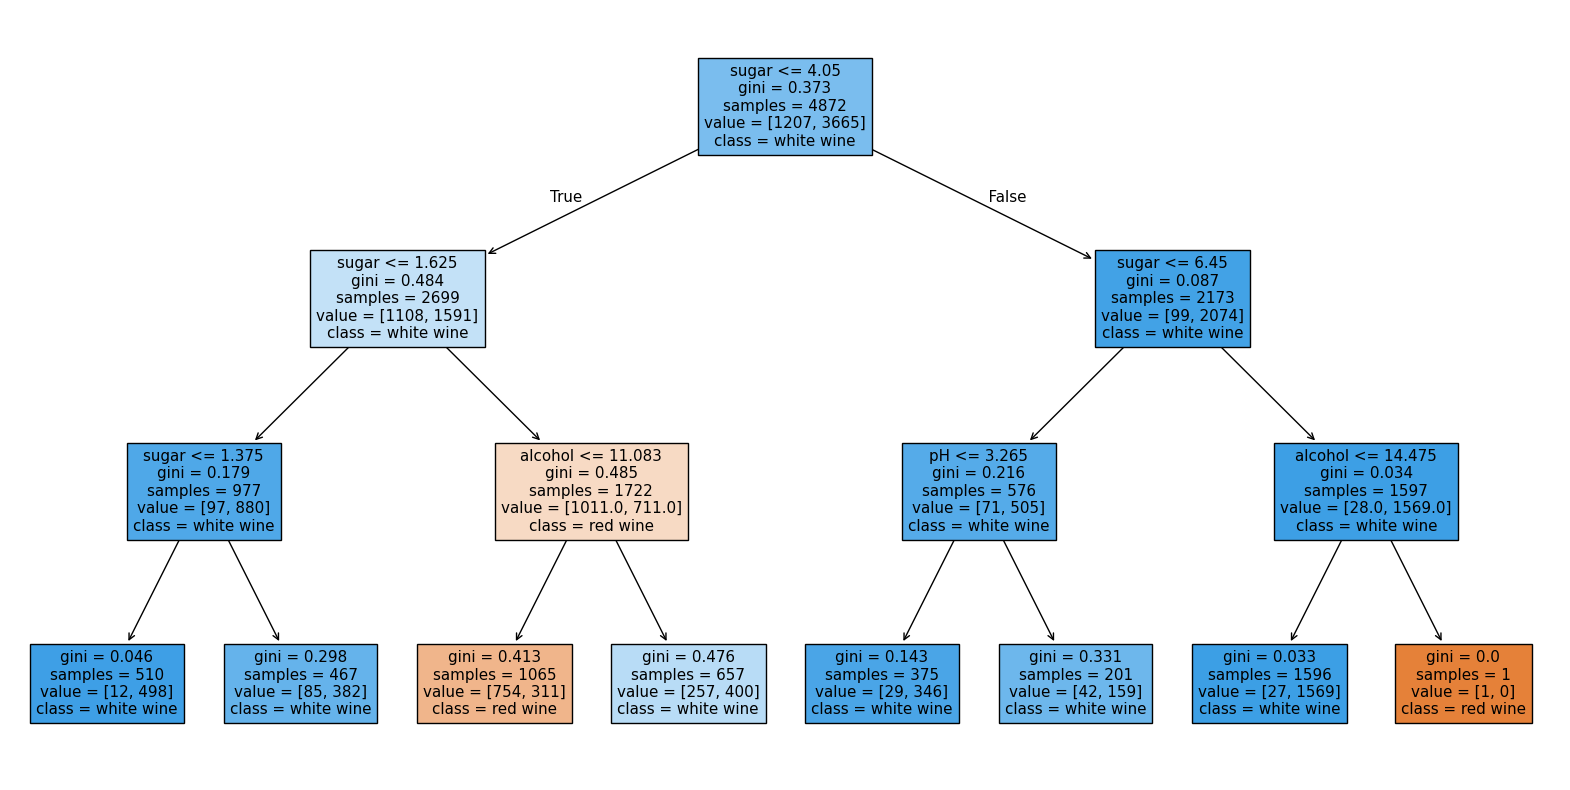

' \nsugar<=-0.284       # DecisionTreeClassifier가 정한 분할 기준 (자식 노드에서 지니계수가 최대로 낮아질 수 있는 분할 기준)\ngini=0.373          # 지니계수 =1 -(음성클래스비율^2 + 양성클래스비율^2)\nsamples=4872        # 현재 노드의 전체 샘플 수\nvalue=[1207,3665]   # 클래스별 샘플 개수 (0번 클래스 1207개. 1번 클래스 3665개)\nclass=white wine    # 현재 노드의 클래스 (value에서 많은 클래스 선택)\n\n'

In [112]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
# plot_tree(dt_clf)
plot_tree(
    dt_clf,
    filled=True,                            # 색 채우기 옵션 (특정 크래스의 비율 표현)
    feature_names=X.columns,                # 특성 이름
    class_names=['red wine','white wine'],   # 클래스 이름
    # max_depth=3
)
plt.savefig('./img/wine_simple.png')        # 이미지 저장
plt.show()

""" 
sugar<=-0.284       # DecisionTreeClassifier가 정한 분할 기준 (자식 노드에서 지니계수가 최대로 낮아질 수 있는 분할 기준)
gini=0.373          # 지니계수 =1 -(음성클래스비율^2 + 양성클래스비율^2)
samples=4872        # 현재 노드의 전체 샘플 수
value=[1207,3665]   # 클래스별 샘플 개수 (0번 클래스 1207개. 1번 클래스 3665개)
class=white wine    # 현재 노드의 클래스 (value에서 많은 클래스 선택)

"""

In [113]:
# 지니 불순도 직접 계산
# 지니계수 =1 -(음성클래스비율^2 + 양성클래스비율^2)
1 - ((1207/4872)**2+(3665/4872)**2)

0.37273200500969317

In [114]:
# 특성 중요도
# [alcohol,sugar,pH] 중요도
dt_clf.feature_importances_

array([0.11483515, 0.87892904, 0.00623581])

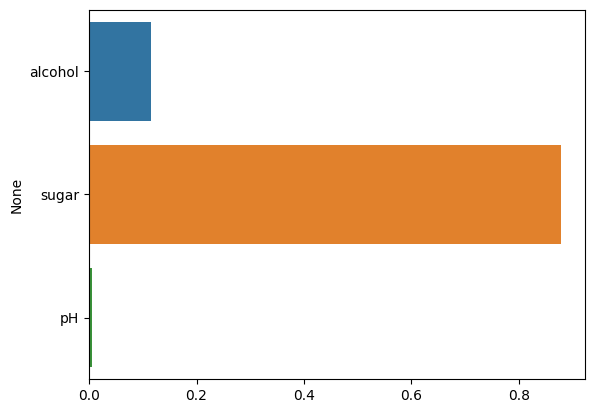

In [115]:
# 특성 중요도 시각화
sns.barplot(x=dt_clf.feature_importances_,y=X.columns,hue=X.columns)
plt.show()

##### iris 다중분류

In [116]:
# 데이터 로드
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_data=load_iris() # dat : X 데이터, target : y데이터

X_train,X_test,y_train,y_test=train_test_split(iris_data.data,iris_data.target,random_state=0)


In [117]:
# 모델 학습 및 평가
from sklearn.tree import DecisionTreeClassifier

dt_clf=DecisionTreeClassifier()

dt_clf.fit(X_train,y_train)

print(dt_clf.score(X_train,y_train),dt_clf.score(X_test,y_test))

1.0 0.9736842105263158


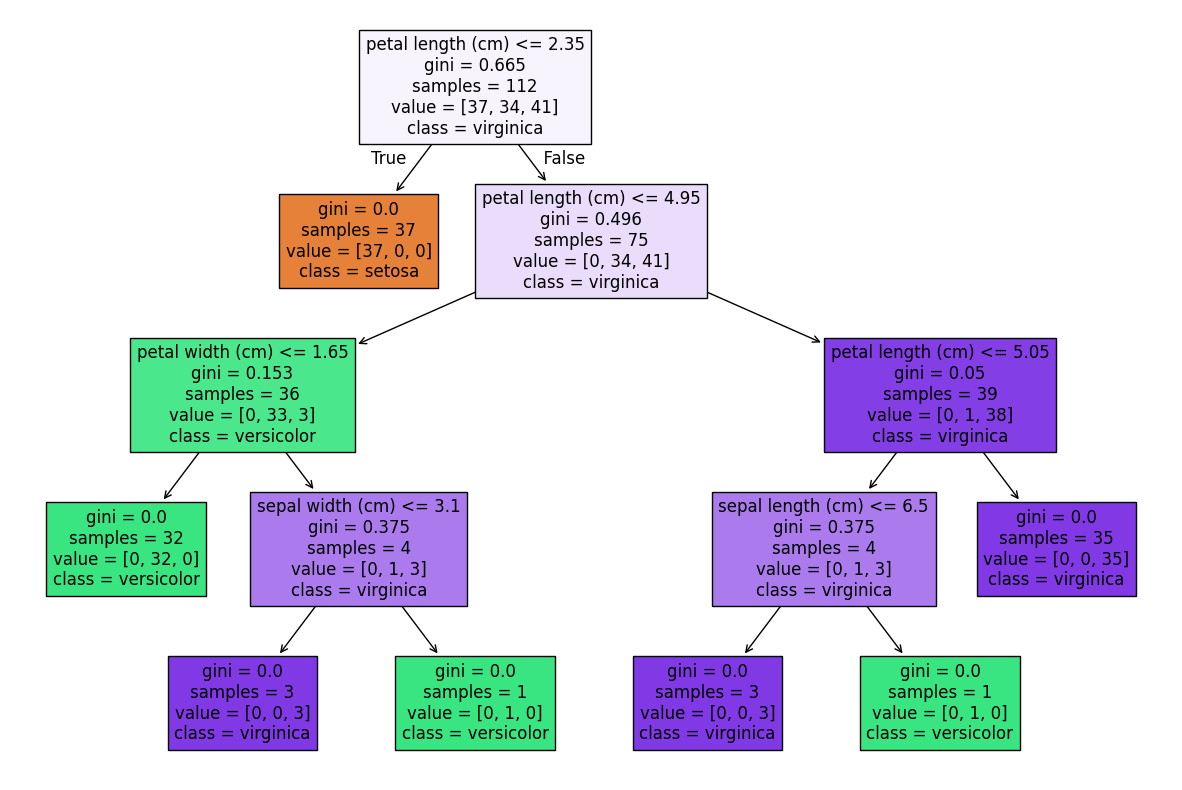

In [118]:
# 트리모델 시각화
from sklearn.tree import plot_tree

plt.figure(figsize=(15,10))

plot_tree(
    dt_clf,
    filled=True,
    feature_names=iris_data.feature_names,
    class_names=iris_data.target_names,
)

plt.show()

# DecisionTreeRegressor - 회귀
- 각 노드에서 MSE를 최소화하는 방향으로 노드 분할
- 각 최종 노드(리프 노드)에서는 각 샘플들의 평균값을 계산해 예측값으로 사용

In [119]:
# 데이터 로드
from sklearn.datasets import fetch_california_housing

housing_data=fetch_california_housing()
housing_df=pd.DataFrame(housing_data.data,columns=housing_data.feature_names)
housing_df[housing_data.target_names[0]]=housing_data.target
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [120]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(housing_data.data,housing_data.target,random_state=0)

In [121]:
# 모델 훈련 및 평가
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score

dt_reg=DecisionTreeRegressor(random_state=0, max_depth=8)

# 학습
dt_reg.fit(X_train,y_train)

# 예측
pred_train=dt_reg.predict(X_train)
pred_test=dt_reg.predict(X_test)

# 평가
mse_train = mean_squared_error(y_train,pred_train)
r2_train= r2_score(y_train,pred_train)

mse_test = mean_squared_error(y_test,pred_test)
r2_test= r2_score(y_test,pred_test)

print(f'train 평가값: {mse_train} | {r2_train}')
print(f'test 평가값: {mse_test} | {r2_test}')

train 평가값: 0.32342609927780885 | 0.7576694150548335
test 평가값: 0.4391632362998888 | 0.6677663736640318


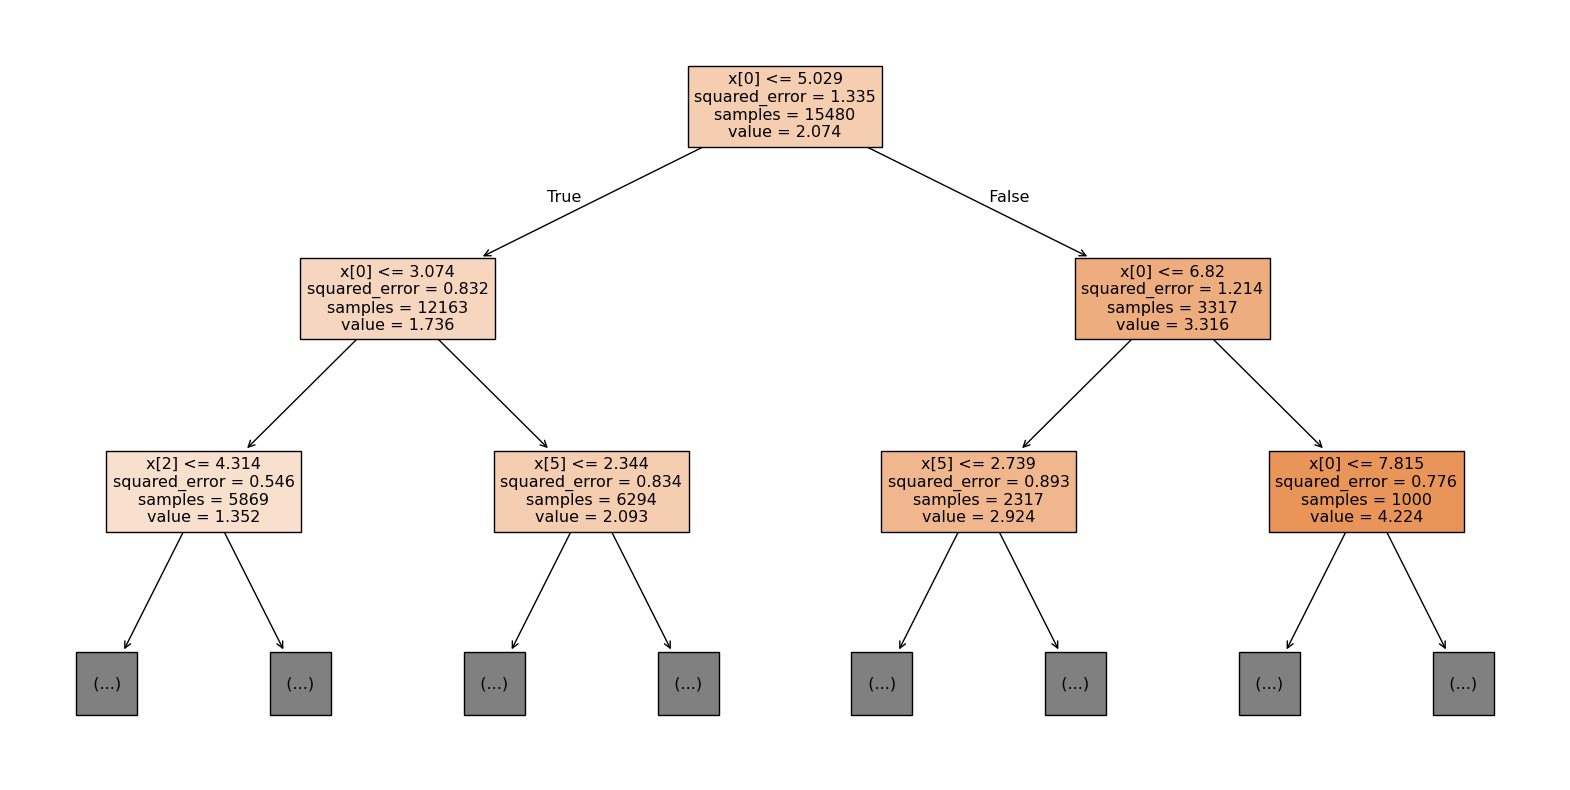

In [122]:
# 시각화
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    dt_reg,
    filled=True,
    max_depth=2
)

plt.show()

<Axes: >

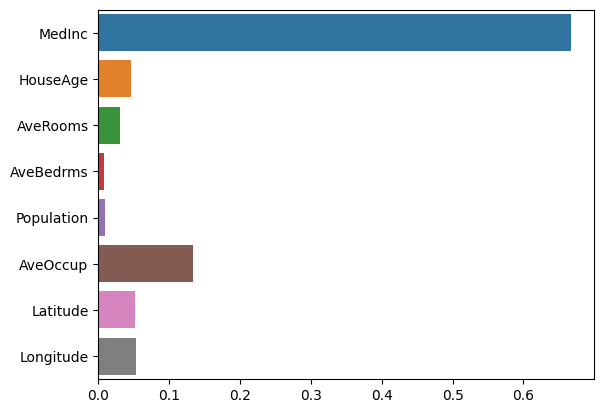

In [147]:
# 특성 중요도
dt_reg.feature_importances_

sns.barplot(
    x=dt_reg.feature_importances_,
    y=housing_data.feature_names,
    hue=housing_data.feature_names
    )